In [1]:
import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

from prednet import PredNet
# from data_utils import SequenceGenerator
from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time

Using TensorFlow backend.


In [2]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

5000


In [3]:
def check_RAD_id(RAD_id):
    mean_list = []
    for k in range(61):
        mean_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().mean())
    mean_list = np.array(mean_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, mean_list[:6])
    if mean_list.mean() < 0:
        return False
    for k in range(59):
        if abs(mean_list[k] + mean_list[k + 2] - 2 * mean_list[k + 1]) > 2:
            return False
    return True

In [4]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-08-29 00:45:59
00:00:00
0 [-0.87143478 -0.88864586 -0.87570966 -0.87651842 -0.85615197 -0.85808025]
00:00:04
100 [0.93458592 0.94748228 0.91407206 0.97729093 0.9896096  0.95768941]
00:00:08
200 [0.63846758 0.81406847 0.84174963 1.11912702 1.17828216 1.40408206]
00:00:12
300 [-0.70275019 -0.60799758 -0.57519691 -0.53383054 -0.47055191 -0.42185489]
00:00:16
400 [3.6213282  3.81463022 3.72164653 3.65255517 3.61006928 3.63974646]
00:00:21
500 [-0.82312819 -0.84708427 -0.86941088 -0.86395672 -0.89204425 -0.87515588]
00:00:25
600 [-0.64371855 -0.6432564  -0.65860295 -0.65442369 -0.6496747  -0.67613276]
00:00:29
700 [7.77424791 0.75098904 0.68460683 0.60291393 0.59950757 0.56755551]
00:00:34
800 [-0.27642121 -0.20599918 -0.12073259 -0.05030657  0.04815519  0.06030653]
00:00:38
900 [-0.85298067 -0.84477751 -0.82603655 -0.79839523 -0.76492524 -0.77512042]
00:00:43
1000 [5.48567137 5.721778   5.83030745 5.96880889 6.05623882 6.2163099 ]
00:00:47
1100 [-0.58297377 -0.59010522 -0.

In [5]:
class myGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
            y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
        return X, y

In [109]:
# tf.reset_default_graph()

save_model = True  # if weights will be saved
weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')  # where weights will be saved
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# # Data files
# train_file = os.path.join(DATA_DIR, 'X_train.hkl')
# train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
# val_file = os.path.join(DATA_DIR, 'X_val.hkl')
# val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')

# Training parameters
nb_epoch = 15
batch_size = 4
samples_per_epoch = 50  # 500
N_seq_val = None  # 100  number of sequences to use for validation

# Model parameters
image_size = 256
nt = 3  # number of timesteps used for sequences in training
image_scalar = 80
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (2, 2)
Ahat_filt_sizes = (2, 2, 2)
R_filt_sizes = (2, 2, 2)
layer_loss_weights = np.array([1., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, A_activation='relu',
                  error_activation='relu', LSTM_inner_activation='sigmoid',
                  output_mode='prediction', return_sequences=False)

inputs = Input(shape=(nt,) + input_shape)
outputs = prednet(inputs)
# outputs = np.empty(shape=(nt,) + input_shape)
# for i in range(nt):
#     temp_outputs = prednet(inputs)
#     outputs[i] = temp_outputs
#     for j in range(nt - 1):
#         inputs[j] = inputs[j + 1]
#     inputs[-1] = temp_outputs

def my_loss(y_true, y_pred):
    w = tf.add(y_true, tf.constant(0.8))
    w = tf.add(y_pred, w)
    loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(100000.0))
    return loss

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-08-29 02:05:45


In [110]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3, 256, 256, 1)    0         
_________________________________________________________________
pred_net_15 (PredNet)        (None, 256, 256, 1)       711705    
Total params: 711,705
Trainable params: 711,705
Non-trainable params: 0
_________________________________________________________________


how to use tensorboard
```bash
python3 /usr/local/lib/python3.5/dist-packages/tensorboard/main.py --logdir='/home/hadoop/Documents/Neutrino/tensorboard_logs' --host=192.168.1.115
rm -rf /home/hadoop/Documents/Neutrino/tensorboard_logs
```

In [111]:
lr_schedule = lambda epoch: 0.003 if epoch < 75 else 0.001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

In [106]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = myGenerator(list_IDs=RAD_id_list[:10], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=10)
valid_generator = myGenerator(list_IDs=RAD_id_list[-10:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1, shuffle=False)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=1000, validation_data=valid_generator, validation_steps=2 ,use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)

start time: 2018-08-29 02:04:04
Epoch 1/10
30/30 [==============================] - 5s 172ms/step - loss: 94.2856 - val_loss: 976.4751

Epoch 2/10
30/30 [==============================] - 5s 173ms/step - loss: 115.3667 - val_loss: 955.8048
Epoch 3/10
30/30 [==============================] - 5s 173ms/step - loss: 88.4641 - val_loss: 979.2525
Epoch 4/10
30/30 [==============================] - 7s 232ms/step - loss: 79.6739 - val_loss: 977.9559
Epoch 5/10
30/30 [==============================] - 7s 231ms/step - loss: 74.3949 - val_loss: 1003.9558
Epoch 6/10
30/30 [==============================] - 7s 235ms/step - loss: 73.3928 - val_loss: 999.7294
Epoch 7/10
30/30 [==============================] - 5s 171ms/step - loss: 69.2056 - val_loss: 1011.8057
Epoch 8/10
30/30 [==============================] - 7s 236ms/step - loss: 67.4276 - val_loss: 1022.8732
Epoch 9/10
30/30 [==============================] - 7s 235ms/step - loss: 66.3134 - val_loss: 1036.9595
Epoch 10/10
30/30 [================

In [ ]:
train_generator = myGenerator(list_IDs=RAD_id_list[:1600], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=10)
valid_generator = myGenerator(list_IDs=RAD_id_list[1800:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=10)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=5000, validation_data=valid_generator, validation_steps=2, callbacks=callbacks)

Epoch 1/5000
10/10 [==============================] - 17s 2s/step - loss: 1002.7437 - val_loss: 775.9602
Epoch 2/5000
10/10 [==============================] - 13s 1s/step - loss: 720.9127 - val_loss: 723.4323
Epoch 3/5000
10/10 [==============================] - 14s 1s/step - loss: 777.9669 - val_loss: 691.5756
Epoch 4/5000
10/10 [==============================] - 13s 1s/step - loss: 740.9449 - val_loss: 703.2819
Epoch 5/5000
10/10 [==============================] - 15s 1s/step - loss: 643.2498 - val_loss: 665.5648
Epoch 6/5000
10/10 [==============================] - 14s 1s/step - loss: 647.9467 - val_loss: 662.0715
Epoch 7/5000
10/10 [==============================] - 14s 1s/step - loss: 641.4453 - val_loss: 696.7500
Epoch 8/5000
10/10 [==============================] - 14s 1s/step - loss: 545.7647 - val_loss: 687.7179
Epoch 9/5000
10/10 [==============================] - 14s 1s/step - loss: 687.4979 - val_loss: 669.6724
Epoch 10/5000
10/10 [==============================] - 14s 1s/s

10/10 [==============================] - 13s 1s/step - loss: 677.8571 - val_loss: 635.1544
Epoch 80/5000
10/10 [==============================] - 13s 1s/step - loss: 583.4716 - val_loss: 634.5561
Epoch 81/5000
10/10 [==============================] - 13s 1s/step - loss: 645.7894 - val_loss: 653.9715
Epoch 82/5000
10/10 [==============================] - 13s 1s/step - loss: 624.7162 - val_loss: 640.2870
Epoch 83/5000
10/10 [==============================] - 13s 1s/step - loss: 656.4865 - val_loss: 646.1831
Epoch 84/5000
10/10 [==============================] - 13s 1s/step - loss: 589.1596 - val_loss: 611.5552
Epoch 85/5000
10/10 [==============================] - 13s 1s/step - loss: 536.2078 - val_loss: 620.4868
Epoch 86/5000
10/10 [==============================] - 13s 1s/step - loss: 574.8042 - val_loss: 604.5515
Epoch 87/5000
10/10 [==============================] - 14s 1s/step - loss: 617.8954 - val_loss: 629.0743
Epoch 88/5000
10/10 [==============================] - 14s 1s/step - 

10/10 [==============================] - 13s 1s/step - loss: 607.3135 - val_loss: 640.4911
Epoch 157/5000
10/10 [==============================] - 13s 1s/step - loss: 649.2274 - val_loss: 633.2678
Epoch 158/5000
10/10 [==============================] - 13s 1s/step - loss: 514.6698 - val_loss: 609.4354
Epoch 159/5000
10/10 [==============================] - 13s 1s/step - loss: 507.4757 - val_loss: 642.6152
Epoch 160/5000
10/10 [==============================] - 13s 1s/step - loss: 712.5425 - val_loss: 623.7401
Epoch 161/5000
10/10 [==============================] - 13s 1s/step - loss: 615.8833 - val_loss: 617.5887
Epoch 162/5000
10/10 [==============================] - 13s 1s/step - loss: 594.9025 - val_loss: 632.1305
Epoch 163/5000
10/10 [==============================] - 13s 1s/step - loss: 627.9055 - val_loss: 640.0383
Epoch 164/5000
10/10 [==============================] - 13s 1s/step - loss: 525.0950 - val_loss: 635.6685
Epoch 165/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 647.2569 - val_loss: 628.9758
Epoch 234/5000
10/10 [==============================] - 13s 1s/step - loss: 571.0728 - val_loss: 606.6293
Epoch 235/5000
10/10 [==============================] - 13s 1s/step - loss: 559.2264 - val_loss: 643.2215
Epoch 236/5000
10/10 [==============================] - 13s 1s/step - loss: 556.8482 - val_loss: 628.0054
Epoch 237/5000
10/10 [==============================] - 14s 1s/step - loss: 610.1383 - val_loss: 642.2676
Epoch 238/5000
10/10 [==============================] - 13s 1s/step - loss: 599.9129 - val_loss: 647.2378
Epoch 239/5000
10/10 [==============================] - 13s 1s/step - loss: 618.3322 - val_loss: 644.6895
Epoch 240/5000
10/10 [==============================] - 13s 1s/step - loss: 660.6268 - val_loss: 649.2701
Epoch 241/5000
10/10 [==============================] - 14s 1s/step - loss: 522.0296 - val_loss: 644.0255
Epoch 242/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 591.1877 - val_loss: 624.6750
Epoch 311/5000
10/10 [==============================] - 13s 1s/step - loss: 534.0802 - val_loss: 612.8614
Epoch 312/5000
10/10 [==============================] - 13s 1s/step - loss: 549.0120 - val_loss: 650.2646
Epoch 313/5000
10/10 [==============================] - 13s 1s/step - loss: 612.6208 - val_loss: 627.7852
Epoch 314/5000
10/10 [==============================] - 13s 1s/step - loss: 552.3153 - val_loss: 624.0245
Epoch 315/5000
10/10 [==============================] - 14s 1s/step - loss: 618.8463 - val_loss: 623.1082
Epoch 316/5000
10/10 [==============================] - 13s 1s/step - loss: 625.9478 - val_loss: 632.2542
Epoch 317/5000
10/10 [==============================] - 13s 1s/step - loss: 591.9778 - val_loss: 634.2529
Epoch 318/5000
10/10 [==============================] - 13s 1s/step - loss: 596.4302 - val_loss: 633.6798
Epoch 319/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 553.5534 - val_loss: 643.8387
Epoch 388/5000
10/10 [==============================] - 13s 1s/step - loss: 596.9094 - val_loss: 619.1786
Epoch 389/5000
10/10 [==============================] - 14s 1s/step - loss: 536.2786 - val_loss: 631.0362
Epoch 390/5000
10/10 [==============================] - 13s 1s/step - loss: 583.4311 - val_loss: 606.9605
Epoch 391/5000
10/10 [==============================] - 13s 1s/step - loss: 656.3744 - val_loss: 607.6864
Epoch 392/5000
10/10 [==============================] - 13s 1s/step - loss: 606.1863 - val_loss: 647.0802
Epoch 393/5000
10/10 [==============================] - 13s 1s/step - loss: 606.9664 - val_loss: 615.6144
Epoch 394/5000
10/10 [==============================] - 13s 1s/step - loss: 605.9416 - val_loss: 611.8713
Epoch 395/5000
10/10 [==============================] - 13s 1s/step - loss: 596.0375 - val_loss: 652.7160
Epoch 396/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 640.1485 - val_loss: 625.1832
Epoch 465/5000
10/10 [==============================] - 13s 1s/step - loss: 476.7985 - val_loss: 628.0192
Epoch 466/5000
10/10 [==============================] - 13s 1s/step - loss: 532.6653 - val_loss: 633.8278
Epoch 467/5000
10/10 [==============================] - 13s 1s/step - loss: 645.8518 - val_loss: 605.3573
Epoch 468/5000
10/10 [==============================] - 13s 1s/step - loss: 652.3264 - val_loss: 647.0922
Epoch 469/5000
10/10 [==============================] - 13s 1s/step - loss: 578.3010 - val_loss: 620.0659
Epoch 470/5000
10/10 [==============================] - 13s 1s/step - loss: 577.1273 - val_loss: 626.1052
Epoch 471/5000
10/10 [==============================] - 13s 1s/step - loss: 600.0068 - val_loss: 592.0263
Epoch 472/5000
10/10 [==============================] - 13s 1s/step - loss: 581.5111 - val_loss: 634.2484
Epoch 473/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 644.2438 - val_loss: 620.2892
Epoch 542/5000
10/10 [==============================] - 13s 1s/step - loss: 481.4593 - val_loss: 639.3918
Epoch 543/5000
10/10 [==============================] - 13s 1s/step - loss: 637.0290 - val_loss: 621.0719
Epoch 544/5000
10/10 [==============================] - 13s 1s/step - loss: 612.0666 - val_loss: 636.9405
Epoch 545/5000
10/10 [==============================] - 13s 1s/step - loss: 549.6953 - val_loss: 622.4446
Epoch 546/5000
10/10 [==============================] - 13s 1s/step - loss: 543.4876 - val_loss: 652.0910
Epoch 547/5000
10/10 [==============================] - 13s 1s/step - loss: 587.2250 - val_loss: 651.1499
Epoch 548/5000
10/10 [==============================] - 13s 1s/step - loss: 648.1556 - val_loss: 650.0319
Epoch 549/5000
10/10 [==============================] - 13s 1s/step - loss: 567.8586 - val_loss: 646.6832
Epoch 550/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 497.3735 - val_loss: 644.9748
Epoch 619/5000
10/10 [==============================] - 13s 1s/step - loss: 616.5321 - val_loss: 617.2626
Epoch 620/5000
10/10 [==============================] - 13s 1s/step - loss: 585.4627 - val_loss: 652.8121
Epoch 621/5000
10/10 [==============================] - 13s 1s/step - loss: 517.2700 - val_loss: 625.4793
Epoch 622/5000
10/10 [==============================] - 13s 1s/step - loss: 624.9519 - val_loss: 629.6973
Epoch 623/5000
10/10 [==============================] - 13s 1s/step - loss: 568.8071 - val_loss: 617.7837
Epoch 624/5000
10/10 [==============================] - 13s 1s/step - loss: 498.6801 - val_loss: 613.6967
Epoch 625/5000
10/10 [==============================] - 13s 1s/step - loss: 556.7952 - val_loss: 645.2916
Epoch 626/5000
10/10 [==============================] - 13s 1s/step - loss: 587.0135 - val_loss: 655.7810
Epoch 627/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 605.6322 - val_loss: 636.0861
Epoch 696/5000
10/10 [==============================] - 13s 1s/step - loss: 517.0055 - val_loss: 640.3203
Epoch 697/5000
10/10 [==============================] - 13s 1s/step - loss: 608.5567 - val_loss: 635.8187
Epoch 698/5000
10/10 [==============================] - 13s 1s/step - loss: 563.3209 - val_loss: 618.2358
Epoch 699/5000
10/10 [==============================] - 13s 1s/step - loss: 551.1090 - val_loss: 658.7667
Epoch 700/5000
10/10 [==============================] - 13s 1s/step - loss: 534.2490 - val_loss: 633.0775
Epoch 701/5000
10/10 [==============================] - 13s 1s/step - loss: 632.4458 - val_loss: 663.3438
Epoch 702/5000
10/10 [==============================] - 13s 1s/step - loss: 512.4320 - val_loss: 633.3326
Epoch 703/5000
10/10 [==============================] - 13s 1s/step - loss: 471.4678 - val_loss: 649.6350
Epoch 704/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 433.4712 - val_loss: 643.8553
Epoch 773/5000
10/10 [==============================] - 13s 1s/step - loss: 525.2592 - val_loss: 658.2374
Epoch 774/5000
10/10 [==============================] - 13s 1s/step - loss: 570.1883 - val_loss: 650.5848
Epoch 775/5000
10/10 [==============================] - 13s 1s/step - loss: 521.4633 - val_loss: 626.5875
Epoch 776/5000
10/10 [==============================] - 13s 1s/step - loss: 537.6985 - val_loss: 655.1469
Epoch 777/5000
10/10 [==============================] - 13s 1s/step - loss: 526.7206 - val_loss: 619.6018
Epoch 778/5000
10/10 [==============================] - 13s 1s/step - loss: 492.0810 - val_loss: 653.4857
Epoch 779/5000
10/10 [==============================] - 14s 1s/step - loss: 571.8768 - val_loss: 660.7533
Epoch 780/5000
10/10 [==============================] - 13s 1s/step - loss: 530.1518 - val_loss: 644.0907
Epoch 781/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 477.7711 - val_loss: 642.0458
Epoch 850/5000
10/10 [==============================] - 13s 1s/step - loss: 542.1924 - val_loss: 657.0239
Epoch 851/5000
10/10 [==============================] - 13s 1s/step - loss: 482.0605 - val_loss: 652.8598
Epoch 852/5000
10/10 [==============================] - 13s 1s/step - loss: 553.5309 - val_loss: 661.2320
Epoch 853/5000
10/10 [==============================] - 13s 1s/step - loss: 543.0909 - val_loss: 651.5119
Epoch 854/5000
10/10 [==============================] - 13s 1s/step - loss: 432.0456 - val_loss: 642.9376
Epoch 855/5000
10/10 [==============================] - 13s 1s/step - loss: 445.7079 - val_loss: 654.9277
Epoch 856/5000
10/10 [==============================] - 13s 1s/step - loss: 568.7664 - val_loss: 672.6983
Epoch 857/5000
10/10 [==============================] - 13s 1s/step - loss: 533.8034 - val_loss: 667.4686
Epoch 858/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 498.0009 - val_loss: 673.9957
Epoch 927/5000
10/10 [==============================] - 13s 1s/step - loss: 513.7029 - val_loss: 616.6398
Epoch 928/5000
10/10 [==============================] - 13s 1s/step - loss: 457.7317 - val_loss: 654.4103
Epoch 929/5000
10/10 [==============================] - 13s 1s/step - loss: 545.3673 - val_loss: 661.5835
Epoch 930/5000
10/10 [==============================] - 13s 1s/step - loss: 467.7043 - val_loss: 665.5679
Epoch 931/5000
10/10 [==============================] - 13s 1s/step - loss: 454.9919 - val_loss: 651.5174
Epoch 932/5000
10/10 [==============================] - 13s 1s/step - loss: 416.1951 - val_loss: 659.7477
Epoch 933/5000
10/10 [==============================] - 13s 1s/step - loss: 569.9035 - val_loss: 641.6681
Epoch 934/5000
10/10 [==============================] - 13s 1s/step - loss: 518.8873 - val_loss: 664.3964
Epoch 935/5000
10/10 [==============================] - 13s 1

10/10 [==============================] - 13s 1s/step - loss: 442.7830 - val_loss: 670.7921
Epoch 1004/5000
10/10 [==============================] - 13s 1s/step - loss: 564.8233 - val_loss: 654.9999
Epoch 1005/5000
10/10 [==============================] - 13s 1s/step - loss: 474.8702 - val_loss: 663.5310
Epoch 1006/5000
10/10 [==============================] - 13s 1s/step - loss: 447.4914 - val_loss: 651.8276
Epoch 1007/5000
10/10 [==============================] - 14s 1s/step - loss: 457.9091 - val_loss: 647.5410
Epoch 1008/5000
10/10 [==============================] - 13s 1s/step - loss: 433.2866 - val_loss: 648.5857
Epoch 1009/5000
10/10 [==============================] - 13s 1s/step - loss: 461.3565 - val_loss: 640.1421
Epoch 1010/5000
10/10 [==============================] - 13s 1s/step - loss: 432.1271 - val_loss: 684.2436
Epoch 1011/5000
10/10 [==============================] - 13s 1s/step - loss: 491.7658 - val_loss: 688.9109
Epoch 1012/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 432.8676 - val_loss: 687.0224
Epoch 1080/5000
10/10 [==============================] - 13s 1s/step - loss: 465.8278 - val_loss: 694.4932
Epoch 1081/5000
10/10 [==============================] - 13s 1s/step - loss: 477.3400 - val_loss: 681.2852
Epoch 1082/5000
10/10 [==============================] - 13s 1s/step - loss: 442.7752 - val_loss: 673.9095
Epoch 1083/5000
10/10 [==============================] - 13s 1s/step - loss: 456.4709 - val_loss: 671.0297
Epoch 1084/5000
10/10 [==============================] - 13s 1s/step - loss: 464.6650 - val_loss: 667.4533
Epoch 1085/5000
10/10 [==============================] - 13s 1s/step - loss: 502.6079 - val_loss: 685.2406
Epoch 1086/5000
10/10 [==============================] - 13s 1s/step - loss: 429.6075 - val_loss: 675.9565
Epoch 1087/5000
10/10 [==============================] - 13s 1s/step - loss: 487.5714 - val_loss: 671.6184
Epoch 1088/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 445.0555 - val_loss: 651.8135
Epoch 1156/5000
10/10 [==============================] - 13s 1s/step - loss: 456.1232 - val_loss: 638.4473
Epoch 1157/5000
10/10 [==============================] - 13s 1s/step - loss: 443.7492 - val_loss: 682.9836
Epoch 1158/5000
10/10 [==============================] - 13s 1s/step - loss: 423.6176 - val_loss: 671.4937
Epoch 1159/5000
10/10 [==============================] - 13s 1s/step - loss: 450.7305 - val_loss: 684.3512
Epoch 1160/5000
10/10 [==============================] - 13s 1s/step - loss: 509.5716 - val_loss: 645.7426
Epoch 1161/5000
10/10 [==============================] - 13s 1s/step - loss: 462.4421 - val_loss: 633.1442
Epoch 1162/5000
10/10 [==============================] - 13s 1s/step - loss: 458.9759 - val_loss: 683.6020
Epoch 1163/5000
10/10 [==============================] - 13s 1s/step - loss: 362.6961 - val_loss: 652.9617
Epoch 1164/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 526.9340 - val_loss: 647.0705
Epoch 1232/5000
10/10 [==============================] - 13s 1s/step - loss: 441.8702 - val_loss: 669.5274
Epoch 1233/5000
10/10 [==============================] - 13s 1s/step - loss: 457.4036 - val_loss: 677.6742
Epoch 1234/5000
10/10 [==============================] - 13s 1s/step - loss: 455.6400 - val_loss: 684.2517
Epoch 1235/5000
10/10 [==============================] - 13s 1s/step - loss: 437.9550 - val_loss: 699.5841
Epoch 1236/5000
10/10 [==============================] - 13s 1s/step - loss: 374.2254 - val_loss: 680.9839
Epoch 1237/5000
10/10 [==============================] - 13s 1s/step - loss: 422.6279 - val_loss: 691.3673
Epoch 1238/5000
10/10 [==============================] - 13s 1s/step - loss: 406.6809 - val_loss: 679.2259
Epoch 1239/5000
10/10 [==============================] - 13s 1s/step - loss: 408.1779 - val_loss: 665.2541
Epoch 1240/5000
10/10 [==============================

10/10 [==============================] - 14s 1s/step - loss: 471.2817 - val_loss: 676.0169
Epoch 1308/5000
10/10 [==============================] - 13s 1s/step - loss: 385.4329 - val_loss: 670.5135
Epoch 1309/5000
10/10 [==============================] - 13s 1s/step - loss: 413.2229 - val_loss: 677.0926
Epoch 1310/5000
10/10 [==============================] - 13s 1s/step - loss: 410.6072 - val_loss: 689.4582
Epoch 1311/5000
10/10 [==============================] - 13s 1s/step - loss: 416.1410 - val_loss: 686.3717
Epoch 1312/5000
10/10 [==============================] - 13s 1s/step - loss: 461.0426 - val_loss: 688.4585
Epoch 1313/5000
10/10 [==============================] - 14s 1s/step - loss: 431.2712 - val_loss: 683.1784
Epoch 1314/5000
10/10 [==============================] - 13s 1s/step - loss: 362.2505 - val_loss: 713.8351
Epoch 1315/5000
10/10 [==============================] - 13s 1s/step - loss: 431.3115 - val_loss: 692.7494
Epoch 1316/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 442.8794 - val_loss: 683.6942
Epoch 1384/5000
10/10 [==============================] - 14s 1s/step - loss: 488.8602 - val_loss: 678.3701
Epoch 1385/5000
10/10 [==============================] - 13s 1s/step - loss: 416.8078 - val_loss: 680.8294
Epoch 1386/5000
10/10 [==============================] - 13s 1s/step - loss: 362.5251 - val_loss: 694.6874
Epoch 1387/5000
10/10 [==============================] - 13s 1s/step - loss: 440.5587 - val_loss: 696.5772
Epoch 1388/5000
10/10 [==============================] - 13s 1s/step - loss: 366.9680 - val_loss: 688.3820
Epoch 1389/5000
10/10 [==============================] - 13s 1s/step - loss: 427.1763 - val_loss: 667.5609
Epoch 1390/5000
10/10 [==============================] - 13s 1s/step - loss: 420.4588 - val_loss: 629.2274
Epoch 1391/5000
10/10 [==============================] - 13s 1s/step - loss: 404.4278 - val_loss: 677.3528
Epoch 1392/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 417.9023 - val_loss: 709.4319
Epoch 1460/5000
10/10 [==============================] - 13s 1s/step - loss: 374.1571 - val_loss: 674.6516
Epoch 1461/5000
10/10 [==============================] - 13s 1s/step - loss: 426.6049 - val_loss: 681.8456
Epoch 1462/5000
10/10 [==============================] - 13s 1s/step - loss: 438.8671 - val_loss: 702.2079
Epoch 1463/5000
10/10 [==============================] - 13s 1s/step - loss: 399.9143 - val_loss: 714.4580
Epoch 1464/5000
10/10 [==============================] - 13s 1s/step - loss: 399.2920 - val_loss: 719.2376
Epoch 1465/5000
10/10 [==============================] - 13s 1s/step - loss: 362.9522 - val_loss: 713.7342
Epoch 1466/5000
10/10 [==============================] - 13s 1s/step - loss: 419.8374 - val_loss: 700.9410
Epoch 1467/5000
10/10 [==============================] - 13s 1s/step - loss: 328.4475 - val_loss: 667.9972
Epoch 1468/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 408.3073 - val_loss: 668.8893
Epoch 1536/5000
10/10 [==============================] - 13s 1s/step - loss: 345.1662 - val_loss: 702.5786
Epoch 1537/5000
10/10 [==============================] - 13s 1s/step - loss: 390.6440 - val_loss: 691.4415
Epoch 1538/5000
10/10 [==============================] - 13s 1s/step - loss: 422.7326 - val_loss: 697.4435
Epoch 1539/5000
10/10 [==============================] - 13s 1s/step - loss: 376.2094 - val_loss: 687.5534
Epoch 1540/5000
10/10 [==============================] - 14s 1s/step - loss: 396.2387 - val_loss: 693.9436
Epoch 1541/5000
10/10 [==============================] - 13s 1s/step - loss: 413.2331 - val_loss: 723.4207
Epoch 1542/5000
10/10 [==============================] - 13s 1s/step - loss: 338.0346 - val_loss: 711.0762
Epoch 1543/5000
10/10 [==============================] - 13s 1s/step - loss: 421.8153 - val_loss: 709.5378
Epoch 1544/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 399.1603 - val_loss: 708.1494
Epoch 1612/5000
10/10 [==============================] - 13s 1s/step - loss: 370.8505 - val_loss: 701.7799
Epoch 1613/5000
10/10 [==============================] - 13s 1s/step - loss: 431.0188 - val_loss: 705.4116
Epoch 1614/5000
10/10 [==============================] - 14s 1s/step - loss: 384.9745 - val_loss: 707.7751
Epoch 1615/5000
10/10 [==============================] - 13s 1s/step - loss: 418.5449 - val_loss: 700.4443
Epoch 1616/5000
10/10 [==============================] - 13s 1s/step - loss: 419.1788 - val_loss: 655.4352
Epoch 1617/5000
10/10 [==============================] - 13s 1s/step - loss: 440.6467 - val_loss: 710.4574
Epoch 1618/5000
10/10 [==============================] - 13s 1s/step - loss: 379.9584 - val_loss: 700.5801
Epoch 1619/5000
10/10 [==============================] - 13s 1s/step - loss: 358.7821 - val_loss: 726.4791
Epoch 1620/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 378.3991 - val_loss: 719.0991
Epoch 1688/5000
10/10 [==============================] - 13s 1s/step - loss: 353.7115 - val_loss: 718.5172
Epoch 1689/5000
10/10 [==============================] - 13s 1s/step - loss: 389.6423 - val_loss: 683.4529
Epoch 1690/5000
10/10 [==============================] - 13s 1s/step - loss: 397.2212 - val_loss: 715.9777
Epoch 1691/5000
10/10 [==============================] - 13s 1s/step - loss: 383.4185 - val_loss: 678.6434
Epoch 1692/5000
10/10 [==============================] - 13s 1s/step - loss: 360.5195 - val_loss: 717.2688
Epoch 1693/5000
10/10 [==============================] - 13s 1s/step - loss: 405.7166 - val_loss: 712.4623
Epoch 1694/5000
10/10 [==============================] - 13s 1s/step - loss: 372.9247 - val_loss: 695.0277
Epoch 1695/5000
10/10 [==============================] - 13s 1s/step - loss: 414.5541 - val_loss: 702.5464
Epoch 1696/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 347.1513 - val_loss: 711.8886
Epoch 1764/5000
10/10 [==============================] - 13s 1s/step - loss: 397.8776 - val_loss: 712.4757
Epoch 1765/5000
10/10 [==============================] - 13s 1s/step - loss: 330.0448 - val_loss: 706.6600
Epoch 1766/5000
10/10 [==============================] - 14s 1s/step - loss: 427.5855 - val_loss: 700.2415
Epoch 1767/5000
10/10 [==============================] - 13s 1s/step - loss: 390.0503 - val_loss: 727.6794
Epoch 1768/5000
10/10 [==============================] - 13s 1s/step - loss: 318.7054 - val_loss: 668.6379
Epoch 1769/5000
10/10 [==============================] - 13s 1s/step - loss: 399.9066 - val_loss: 720.4631
Epoch 1770/5000
10/10 [==============================] - 13s 1s/step - loss: 433.8477 - val_loss: 689.8827
Epoch 1771/5000
10/10 [==============================] - 13s 1s/step - loss: 386.2783 - val_loss: 702.3675
Epoch 1772/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 393.3338 - val_loss: 724.4729
Epoch 1840/5000
10/10 [==============================] - 13s 1s/step - loss: 334.9359 - val_loss: 708.6045
Epoch 1841/5000
10/10 [==============================] - 13s 1s/step - loss: 410.4858 - val_loss: 693.3301
Epoch 1842/5000
10/10 [==============================] - 13s 1s/step - loss: 349.1230 - val_loss: 727.5148
Epoch 1843/5000
10/10 [==============================] - 13s 1s/step - loss: 340.1889 - val_loss: 724.9173
Epoch 1844/5000
10/10 [==============================] - 13s 1s/step - loss: 404.3375 - val_loss: 720.4525
Epoch 1845/5000
10/10 [==============================] - 13s 1s/step - loss: 378.7235 - val_loss: 731.9176
Epoch 1846/5000
10/10 [==============================] - 13s 1s/step - loss: 384.3841 - val_loss: 713.3202
Epoch 1847/5000
10/10 [==============================] - 13s 1s/step - loss: 317.0488 - val_loss: 720.3420
Epoch 1848/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 356.0577 - val_loss: 731.0696
Epoch 1916/5000
10/10 [==============================] - 13s 1s/step - loss: 359.3416 - val_loss: 748.1440
Epoch 1917/5000
10/10 [==============================] - 13s 1s/step - loss: 384.4740 - val_loss: 746.0415
Epoch 1918/5000
10/10 [==============================] - 13s 1s/step - loss: 405.7216 - val_loss: 689.5438
Epoch 1919/5000
10/10 [==============================] - 13s 1s/step - loss: 328.9762 - val_loss: 728.3312
Epoch 1920/5000
10/10 [==============================] - 13s 1s/step - loss: 354.0646 - val_loss: 748.2859
Epoch 1921/5000
10/10 [==============================] - 13s 1s/step - loss: 382.4892 - val_loss: 714.7488
Epoch 1922/5000
10/10 [==============================] - 13s 1s/step - loss: 355.0321 - val_loss: 717.7955
Epoch 1923/5000
10/10 [==============================] - 13s 1s/step - loss: 372.6274 - val_loss: 705.0010
Epoch 1924/5000
10/10 [==============================

10/10 [==============================] - 13s 1s/step - loss: 333.0521 - val_loss: 711.3828
Epoch 1992/5000
10/10 [==============================] - 13s 1s/step - loss: 329.6766 - val_loss: 715.8348
Epoch 1993/5000
10/10 [==============================] - 13s 1s/step - loss: 366.3095 - val_loss: 704.7808
Epoch 1994/5000
10/10 [==============================] - 13s 1s/step - loss: 374.8008 - val_loss: 714.4815
Epoch 1995/5000
10/10 [==============================] - 13s 1s/step - loss: 369.7674 - val_loss: 747.1713
Epoch 1996/5000
10/10 [==============================] - 13s 1s/step - loss: 385.9553 - val_loss: 726.0700
Epoch 1997/5000
10/10 [==============================] - 13s 1s/step - loss: 331.7130 - val_loss: 703.0634
Epoch 1998/5000
10/10 [==============================] - 13s 1s/step - loss: 359.4348 - val_loss: 725.2732
Epoch 1999/5000
10/10 [==============================] - 13s 1s/step - loss: 373.7994 - val_loss: 735.4062
Epoch 2000/5000
10/10 [==============================

In [107]:
train_generator.on_epoch_end()
valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][0]:
    x, y_ = data
    break
y = model.predict(x)

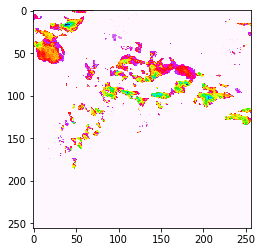

↓↓↓下面的是真实值，上面的是上一张↑↑↑


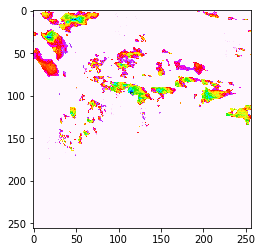

↓↓↓下面的是模型的输出，上面的是真实值↑↑↑


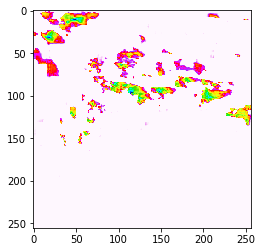

In [108]:
plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
plt.imshow(y[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()

In [52]:
history.history

NameError: name 'history' is not defined

In [ ]:
RAD_id = RAD_id_list[3]
x_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
x_matrix = x_matrix.reshape((1, nt, image_size, image_size, 1))
y_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 10)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
y_matrix = y_matrix.reshape((1, nt, image_size, image_size, 1))

In [ ]:
plt.imshow(a.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
plt.imshow(b.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
input_shape = list(model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))

In [ ]:
print(x_matrix.shape)
print(y_matrix.shape)
print(a.shape)

In [ ]:
print(model.get_input_shape_at(0))
print(model.get_output_shape_at(0))

In [ ]:
%lsmagic

In [ ]:
%quickref